In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

from torch.utils.data import DataLoader
from dataset import LargeDataset, ColorJitter, RandomFilter, RandomTranspose, ToTensor

data = LargeDataset.load('../products/json/data.json', path='../resources/')

random.seed(0)
random.shuffle(data)

trainset = ToTensor(RandomTranspose(RandomFilter(ColorJitter(LargeDataset(data[:350], shuffle=True)))))
validset = ToTensor(RandomTranspose(RandomFilter(ColorJitter(LargeDataset(data[350:400], shuffle=True)))))

print('Training size = {}'.format(len(trainset)))
print('Validation size = {}'.format(len(validset)))

Training size = 29307
Validation size = 5314


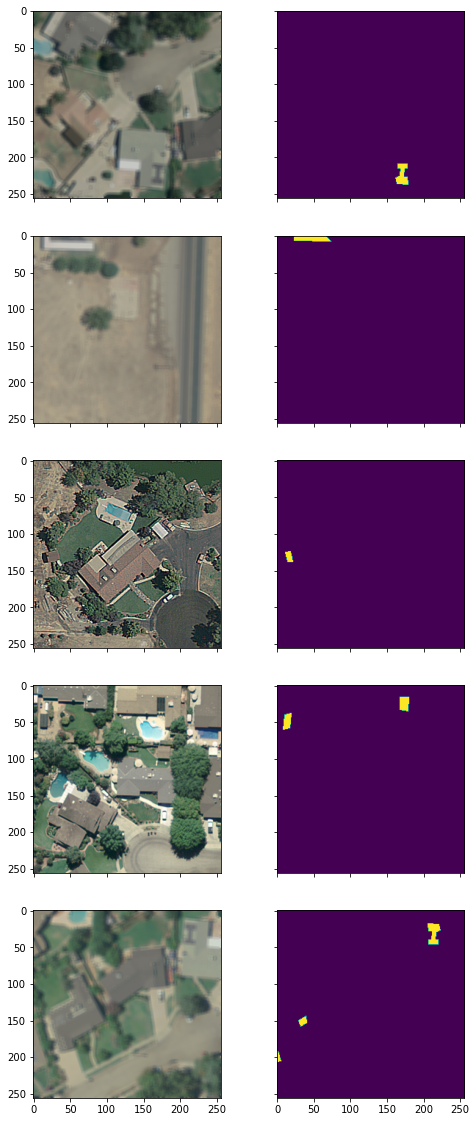

In [3]:
from torch.utils.data import DataLoader
from plots import plot_alongside

trainloader = DataLoader(trainset, batch_size=5)
validloader = DataLoader(validset, batch_size=5)

for inputs, targets in trainloader:
    break

plot_alongside(inputs, targets)

In [4]:
import torch
from torchsummary import summary
from models import UNet

model = UNet(3, 1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.load_state_dict(torch.load('../products/models/unet_robust_032.pth', map_location=device))

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

In [5]:
import train
import numpy as np
from criterions import DiceLoss, TP, TN, FP, FN

metrics = train.eval(model, validloader, [DiceLoss(), TP(), TN(), FP(), FN()])

print('DiceLoss, TP, TN, FP, FN =', np.mean(metrics, axis=0), '+-', np.std(metrics, axis=0))

DiceLoss, TP, TN, FP, FN = [2.70212955e-01 2.54278511e+03 3.23518014e+05 3.56321128e+02
 1.20122995e+03] +- [1.84116425e-01 3.44591116e+03 5.58466469e+03 3.75769834e+02
 2.93091873e+03]


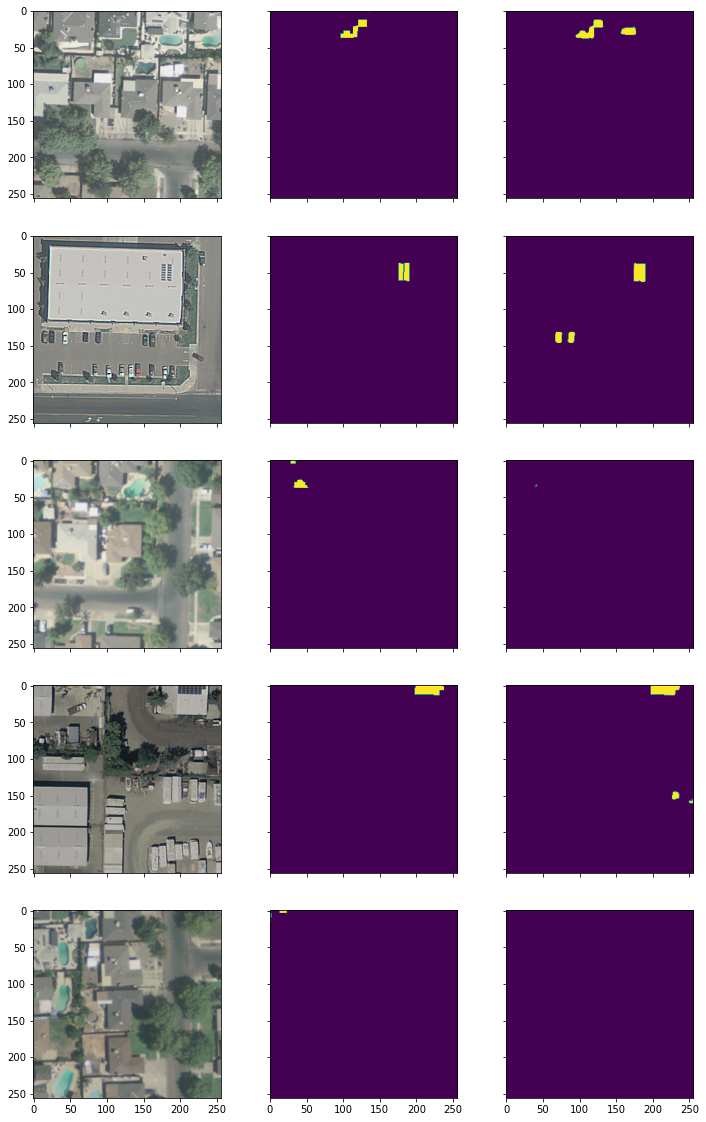

In [6]:
model.eval()

with torch.no_grad():
    for inputs, targets in validloader:
        break

    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)

plot_alongside(
    inputs.cpu(),
    targets.cpu(),
    outputs.cpu()
)